<img alt="Colaboratory logo" width="25%" src="https://github.com/marcelomonier/airbnb_project/blob/main/logo_moment.png?raw=true">



---

## Séries Temporais - Facebook Prophet

Nossa ferramenta, no momento para fazer previsões em séries temporais será o `Prophet`, que foi desenvolvido pelo Facebook.

<center>
<img src="https://miro.medium.com/v2/resize:fit:2000/1*47bsK-JkulWuJ_U8weyH-w.jpeg" width="50%"></center>

O Prophet é bastante robusto, simples e fácil de usar. Vocês vão encontrar na internet exemplos de código utilizando o Prophet sem nem se preoucupar se a Série Temporal é estacionária. Em alguns casos o resultado é bom, mas nem sempre.

### Testes Estatísticos e ARIMA
Um pré-requisito para que possamos fazer previsões em cima de uma TS é ela ser estacionária.

De maneira simplificada, ser estacionária significa ter a **média, variância e covariância** permanecendo **constante** ao longo da dimensão temporal. Vamos entender visualmente o que isso significa.

<center>
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/ns5-e1536673990684.png" width="50%"></center>

No primeiro plot, há uma tendência de alta. Ou seja, a sua média está aumentando conforme o tempo passa. No segundo plot, apesar de não haver uma variação na tendência, a variância (não constante) está interferindo na sua amplitude. Por fim, o último exibe o comportamento típico de quando a covariância varia em função do tempo.

**E como se pareceria uma série estacionária?**

Uma TS com média, variância e covariância constante seria parecida com o plot abaixo.

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/ns6-e1536674898419.png" width="20%"></center>

**Como verificar se uma TS é estacionária?**

Há muitas maneiras se fazer essa verificação. Por exemplo:

* **Olhar os plots -** Em muitos casos, durante a análise exploratória você já vai identificar visualmente se uma TS é estacionária ou não.
* **Resumo estatístico -** Você pode gerar um resumo com as principais informações estatísticas da TS, e verificar se há algum indício da estacionaridade.
* **Testes estatísticos -** São testes que possuem a capacidade de nos dizer se uma TS é estacionária ou não, sempre se baseando em métodos científicos.

Nesta projeto, mais pra frente, realizaremos um teste estatístico específico para identificar se nossa TS é estacionária ou não, o teste ***Augmented Dickey Fuller (ADF)***

### Teste ADF

O ADF é um dos testes estatísticos mais usados para TS. Suas hipóteses nula e alternativa são:

* A Hipótese Nula ($H_0$) do teste é que a TS **não é estacionária**. Ou seja, possui algum tipo de dependência em relação ao tempo.
* A Hipótese Alternativa ($H_1$) **rejeita a hipótese nula**, ou seja, que a TS é estacionária.

Vamos ver como isso vai acontecer no nosso projeto específico.


## Preparando os Dados

Primeiro de tudo, precisamos preparar os dados para serem utilizados com o Prophet. Ele precisa de um tipo muito específico de dataframe para funcionar. Precisamos de:

* Data como uma coluna chamada `ds`.
* Vendas como uma coluna chamada `y`.

No caso específico desse notebook, nós já trouxemos os dados dessa forma, mas normalmente precisaremos fazer um tratamento do nosso conjunto para chegar a esse formato.


In [ ]:
# importando os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importando o Prophet
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
# importando os dados
df_ts = pd.read_csv('https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/df_ts.csv')
df_ts.head()

ds      y
0  2018-01-01  43432
1  2018-01-02  43181
2  2018-01-03  43298
3  2018-01-04  42216
4  2018-01-05  42001

## Teste ADF

Diferente de alguns projetos que vemos com o Prophet, vamos fazer o teste para descobrir se nossa série é estacionária. O teste utilizado será o ***Augmented Dickey Fuller (ADF)***.

Como bem disse o Carlos:
> Normalmente, rejeitamos $H_0$ quando o *p-value* é menor ou igual a um determinado nível de significância. Normalmente, esse nível de significância é igual a 0.01 (1%), 0.05 (5%) ou até mesmo 0.1 (10%).

> Quanto menor o *p-value*, mais evidências contra a hipótese nula você tem. Por exemplo, caso seja usado $\text{p-value} = 0.05$, rejeitamos a $H_0$ com um nível de confiança de 95%.

> Caso o valor do teste fique acima do *threshold*, falharemos em rejeitar a hipótese nula. **Atenção, isso não significa que $H_0$ é verdadeira.** Significa apenas que o experimento não encontrou evidências para rejeitá-la.

Vamos ver como a nossa série se sai.

In [ ]:
# importanto o pacote
from statsmodels.tsa.stattools import adfuller
# extraindo os valores
X = df_ts.y

# aplicando o ADF e imprimindo os resultados.
result = adfuller(X)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result[0]))
print('P Value: {:.10f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value));

Augmented Dickey–Fuller
Statistical Test: -2.3601
P Value: 0.1533303754
Critical Values:
	1%: -3.4365
	5%: -2.8642
	10%: -2.5682


## Tamanho das Previsões

Ao lidar com previsões em Séries Temporais precisamos entender que quanto maior o período que estamos tentando prever, menos confiança teremos nos resultados. Dessa forma, mesmo tendo anos de registros de vendas, vamos fazer as nossas previsões para um período de 30 dias.

In [ ]:
# definindo o tamanho da previsão para trinta dias
prediction_size = 30
train_df = df_ts[:-prediction_size]

Agora que temos o nosso conjunto de teste, vamos instanciar e treinar nosso modelo, e fazer nossas previsões.

In [ ]:
# instanciando o modelo
b = Prophet()

# treinando o modelo
b.fit(train_df)

# fazendo previsões
future = b.make_future_dataframe(periods=prediction_size)

forecast = b.predict(future)

forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2018-01-01  45500.853803  40987.727624  43831.738993  45500.853803   
1 2018-01-02  45499.907965  41142.597291  44308.538488  45499.907965   
2 2018-01-03  45498.962128  41488.914608  44588.734817  45498.962128   
3 2018-01-04  45498.016291  41994.493937  45066.870980  45498.016291   
4 2018-01-05  45497.070453  42567.833406  45719.036761  45497.070453   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  45500.853803    -3084.243800          -3084.243800          -3084.243800   
1  45499.907965    -2801.450481          -2801.450481          -2801.450481   
2  45498.962128    -2462.271822          -2462.271822          -2462.271822   
3  45498.016291    -1982.957626          -1982.957626          -1982.957626   
4  45497.070453    -1341.551500          -1341.551500          -1341.551500   

       weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
0 -899.860727   -899.860727   -899.860727 -2184.383074  -2184.383074   
1 -616.596197   -616.596197   -616.596197 -2184.854283  -2184.854283   
2 -275.759145   -275.759145   -275.759145 -2186.512677  -2186.512677   
3  206.208817    206.208817    206.208817 -2189.166443  -2189.166443   
4  851.042007    851.042007    851.042007 -2192.593507  -2192.593507   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0  -2184.383074                   0.0                         0.0   
1  -2184.854283                   0.0                         0.0   
2  -2186.512677                   0.0                         0.0   
3  -2189.166443                   0.0                         0.0   
4  -2192.593507                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  42416.610002  
1                         0.0  42698.457485  
2                         0.0  43036.690306  
3                         0.0  43515.058665  
4                         0.0  44155.518954

O Prophet traz em seu resultado de previsões diversas informações, entre elas, temos o `yhat`, que são nossas previsões. Além disso temos também os limites inferiores e superiores (`yhat_lower`, `yhat_upper`, respectivamente) entre outras informações que podem ser úteis para um projeto real.

Visualizar as previsões também é super fácil, como podemos ver abaixo:

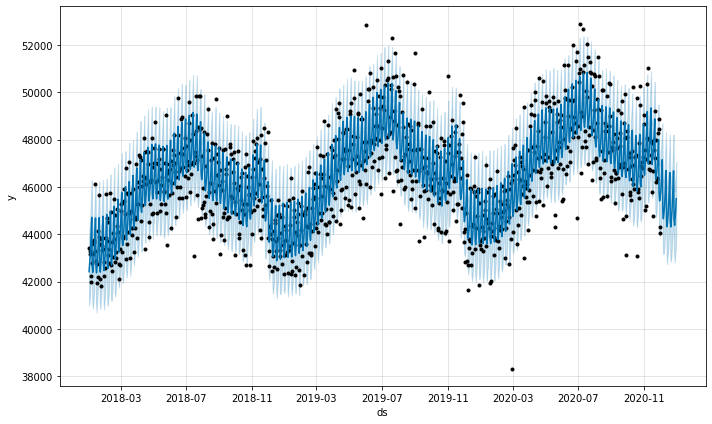

In [ ]:
# plotando as previsões
b.plot(forecast).savefig('forecast_non_stationary.png')

Além disso, também podemos plotar os componentes da nossa previsão.

Abaixo, podemos ver:

* Tendência Geral
* Tendência Semanal
* Tendência Anual


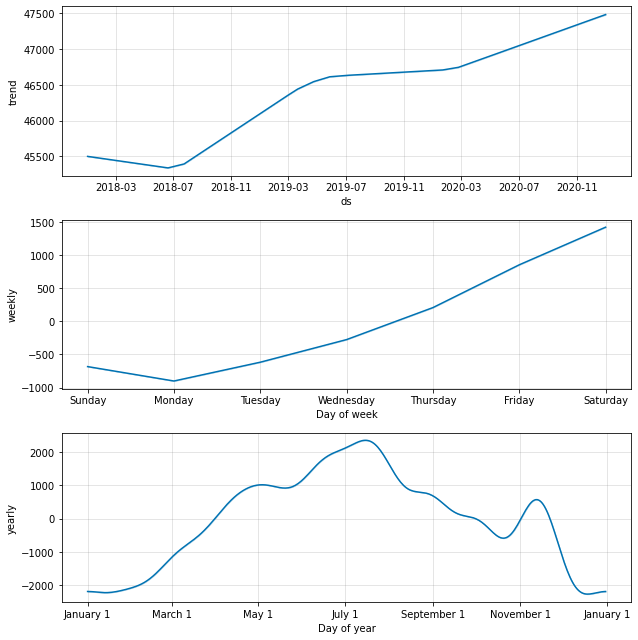

In [ ]:
# plotando componentes
b.plot_components(forecast).savefig('non_st_components.png')

## Conclusões - Série Não-Estacionária
Tudo isso parece lindo e perfeito, mas como saber se nossas previsões estão boas de verdade?

Para isso utilizaremos as seguintes métricas:

* Mean Absolute Percentage Error - Mostra quanto as nossas previsões diferem do valor real em porcentagem.
* Mean Absolute Error - Valor absoluto do nosso erro na previsão em relação à série real.

Abaixo temos uma função para calcular o MAPE e MAE da nossa série.

In [ ]:
# definindo a função
def make_comparison_dataframe(historical, forecast):
  return forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(historical.set_index('ds'))

cmp_df = make_comparison_dataframe(df_ts, forecast)

def calculate_forecast_errors(df_ts, prediction_size):

  df = df_ts.copy()
  df['e'] = df['y'] - df['yhat']
  df['p'] = 100 * df['e'] / df['y']
  predicted_part = df[-prediction_size:]

  error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

  return{'MAPE': error_mean('p'), 'MAE': error_mean('e')}

# imprimindo o MAPE e MAE
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
  print(err_name, err_value)

MAPE nan
MAE nan


In [ ]:
cmp_df.head()

yhat    yhat_lower    yhat_upper   y
ds                                                               
2018-01-01 00:00:00  42416.610002  40987.727624  43831.738993 NaN
2018-01-02 00:00:00  42698.457485  41142.597291  44308.538488 NaN
2018-01-03 00:00:00  43036.690306  41488.914608  44588.734817 NaN
2018-01-04 00:00:00  43515.058665  41994.493937  45066.870980 NaN
2018-01-05 00:00:00  44155.518954  42567.833406  45719.036761 NaN

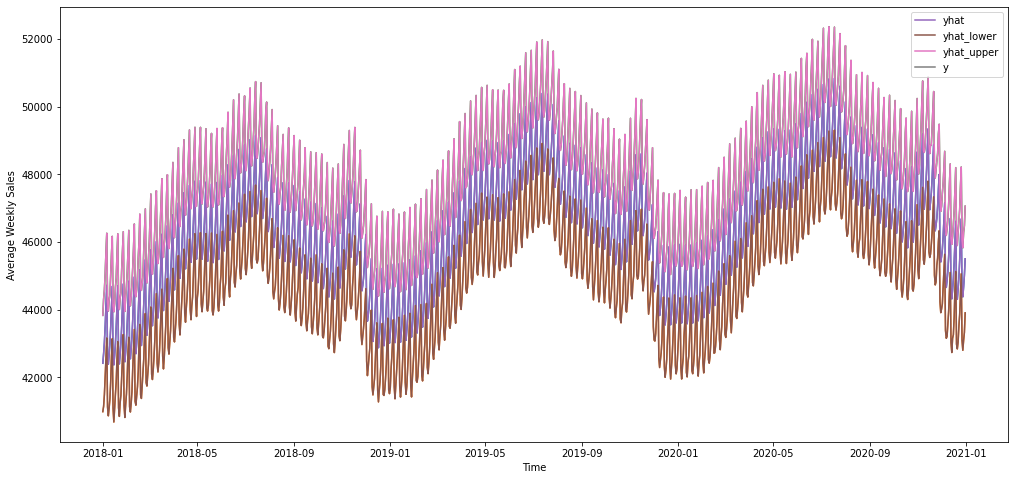

In [ ]:
# visualizando os resultados
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])

plt.xlabel('Time')
plt.ylabel('Average Weekly Sales')
ax.plot(cmp_df['yhat'], label='yhat')
ax.plot(cmp_df['yhat_lower'], label='yhat_lower')
ax.plot(cmp_df['yhat_upper'], label='yhat_upper')
ax.plot(cmp_df['y'], label='y')
ax.legend()
plt.savefig('non_st_yhat.png')
plt.show()

Esses resultados podem parecer bons, mas estamos tendo um erro absoluto grande dentro do contexto que estamos lidando.

Esse modelo vai servir bem como baseline. Agora, vamos transformar a série em estacionária e rodar novamente!

## Série Estacionária

Mais uma vez, não vou ser exaustivo nesse ponto que já abordamos, mas vou trazer o passo a passo trazido pelo Carlos para transformamos a série em estacionária.

> Para transformar uma TS em estacionária, precisamos remover a tendência e a sazonalidade que há nos dados originais. Para isso, existem diversas técnicas que podem ser usadas.

> Uma bom começo é aplicar o $log$ a fim de reduzirmos a magnitude dos valores da TS. Na sequência, subtraímos a média móvel de um determinado período em relação ao $log$ da TS.

In [ ]:
# preparando os dados
df_ts.index = pd.to_datetime(df_ts['ds'], format="%Y-%m-%d")
df_ts.drop('ds', axis=1, inplace=True)
df_ts.head()

y
ds               
2018-01-01  43432
2018-01-02  43181
2018-01-03  43298
2018-01-04  42216
2018-01-05  42001

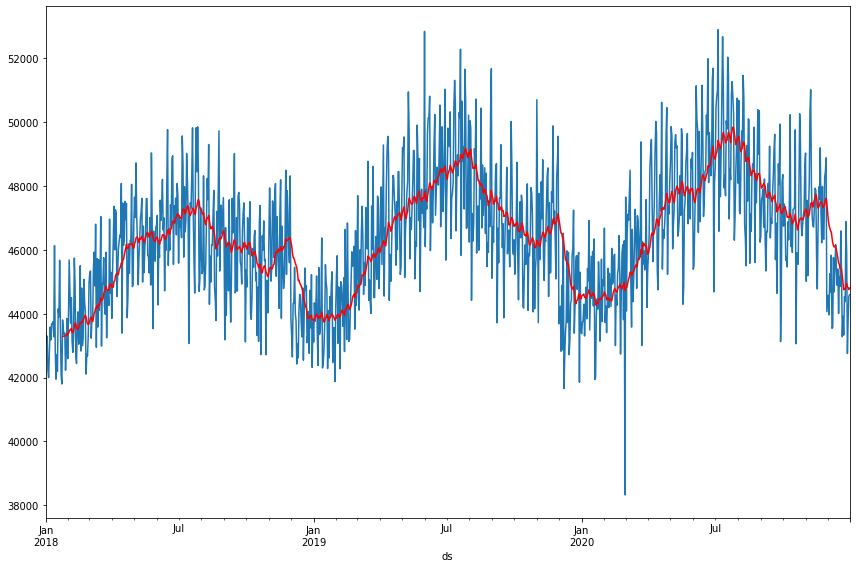

In [ ]:
# checando o plot original
ma = df_ts.rolling(24).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_ts.plot(ax=ax, legend=False)
ma.plot(ax=ax, color='r', legend=False)
plt.tight_layout();

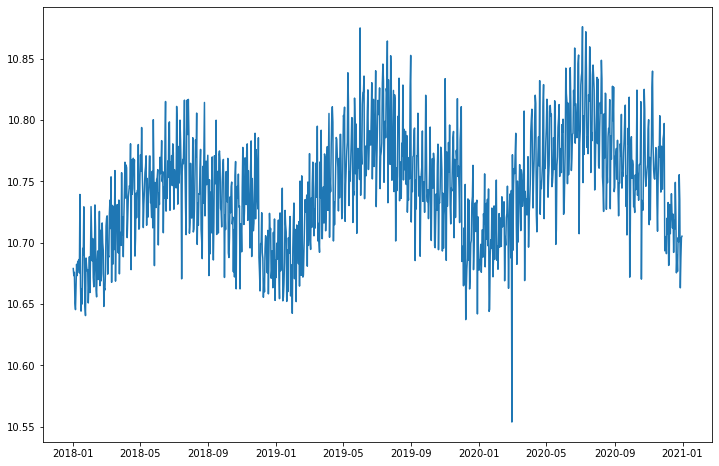

In [ ]:
# aplicando o log
fig, ax = plt.subplots(figsize=(12,8))
ts_log = np.log(df_ts)
plt.plot(ts_log);

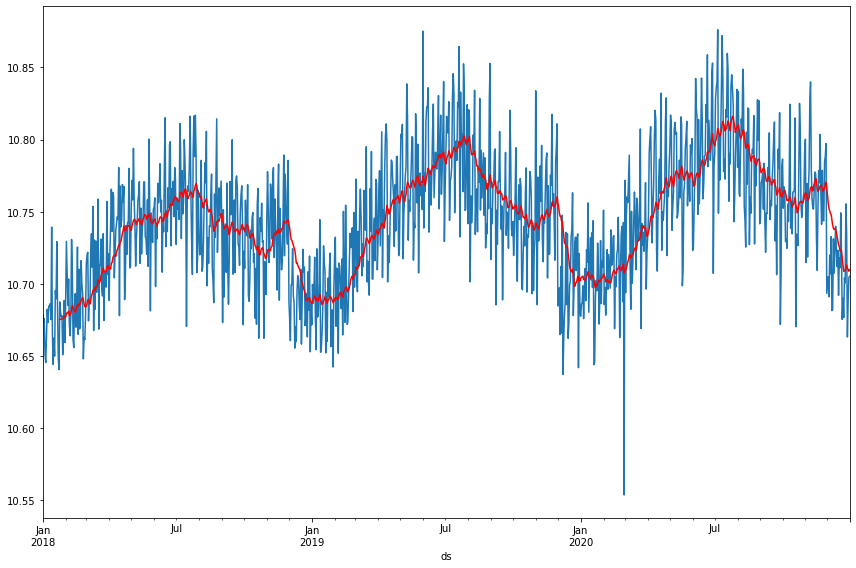

In [ ]:
# aplicando o log
df_log = np.log(df_ts)
ma_log = df_log.rolling(24).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, color='r', legend=False)
plt.tight_layout()

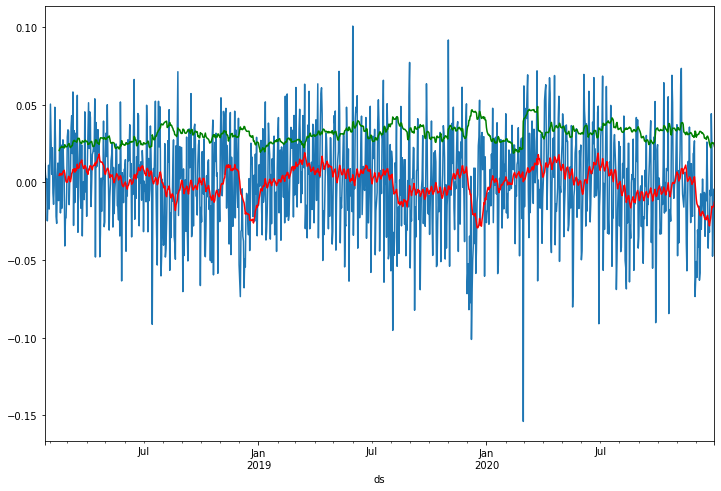

In [ ]:
# subtraindo a média do log nos dados
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(24).mean()
std_sub = df_sub.rolling(24).std()

fig, ax = plt.subplots(figsize=(12,8))
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, color='r', legend=False)
std_sub.plot(ax=ax, color='g', legend=False)
plt.show();

In [ ]:
# repetindo o ADF
X_sub = df_sub.y.values

# aplicando o ADF e imprimindo os resultados
result_sub = adfuller(X_sub)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value));

Augmented Dickey–Fuller
Statistical Test: -5.6436
P Value: 0.0000010231
Critical Values:
	1%: -3.4366
	5%: -2.8643
	10%: -2.5682


Bingo!

Agora temos uma comprovação com nível de confiança bem mais alto para considerar a nossa série estacionária.

Existe outra técnica que podemos utilizar para potencializar esses resultados que é a diferenciação. Citando o Carlos novamente:

> #### Diferenciação

Uma outra técnica simples que ajuda a tornar TS mais estacionárias é a diferenciação.

Apenas calculando a diferença entre duas observações possíveis, é possível incrementar ainda mais o desempenho no ADF.

$$value(t) = observation(t) - observation(t -1)$$

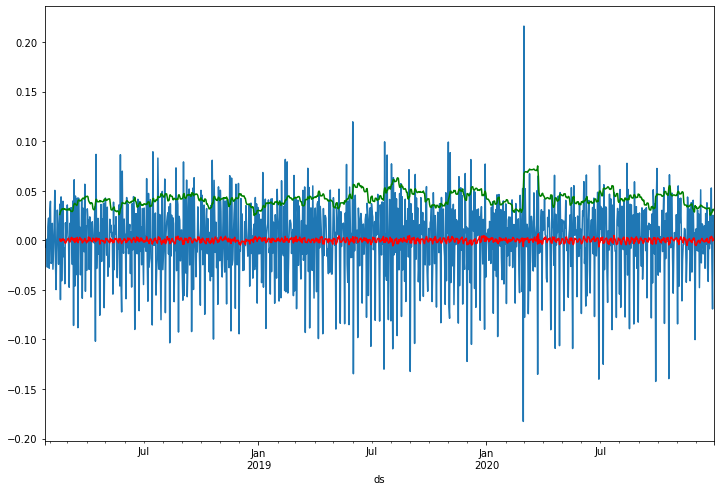

Augmented Dickey–Fuller
Statistical Test: -5.6436
P Value: 0.0000010231
Critical Values:
	1%: -3.4366
	5%: -2.8643
	10%: -2.5682


In [ ]:
# aplicando a diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(24).mean()
std_diff = df_diff.rolling(24).std()

fig, ax = plt.subplots(figsize=(12,8))
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, color='r', legend=False)
std_diff.plot(ax=ax, color='g', legend=False)
plt.show()

# extraindo os valores
X_diff = df_diff.y.dropna().values

# aplicando o ADF e imprimindo os resultados
result_diff = adfuller(X_diff)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

No nosso caso, não tivemos modificações, mas achei interessante trazer novamente, para o caso de você precisar disso pra um outro projeto.

De qualquer forma, vamos seguir!

O primeiro passo é retomar o formato que o Prophet precisa.

In [ ]:
# transformando no formato do Prophet
df_log.reset_index(inplace=True)

In [ ]:
# definindo o tamanho da previsão
prediction_size = 30
train_df = df_log[:-prediction_size]

In [ ]:
# instanciando o modelo
m = Prophet()

# treinando o modelo
m.fit(train_df)

# fazer previsões
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-01-01  10.727495   10.625903   10.691171    10.727495    10.727495   
1 2018-01-02  10.727461   10.628751   10.698178    10.727461    10.727461   
2 2018-01-03  10.727426   10.636270   10.705417    10.727426    10.727426   
3 2018-01-04  10.727392   10.650541   10.716332    10.727392    10.727392   
4 2018-01-05  10.727358   10.664361   10.730595    10.727358    10.727358   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -0.068241             -0.068241             -0.068241 -0.019148   
1       -0.062159             -0.062159             -0.062159 -0.012997   
2       -0.054852             -0.054852             -0.054852 -0.005592   
3       -0.044598             -0.044598             -0.044598  0.004785   
4       -0.031253             -0.031253             -0.031253  0.018272   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -0.019148     -0.019148 -0.049093     -0.049093     -0.049093   
1     -0.012997     -0.012997 -0.049161     -0.049161     -0.049161   
2     -0.005592     -0.005592 -0.049260     -0.049260     -0.049260   
3      0.004785      0.004785 -0.049383     -0.049383     -0.049383   
4      0.018272      0.018272 -0.049525     -0.049525     -0.049525   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  10.659254  
1                         0.0  10.665302  
2                         0.0  10.672574  
3                         0.0  10.682794  
4                         0.0  10.696104

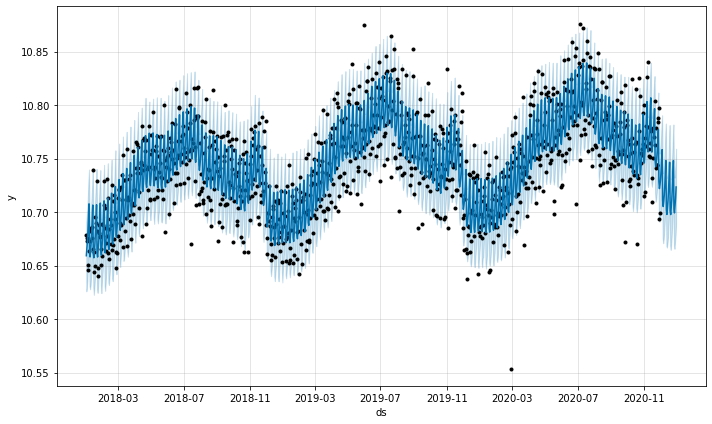

In [ ]:
# plotando a previsão
m.plot(forecast).savefig('st_forecast.png')

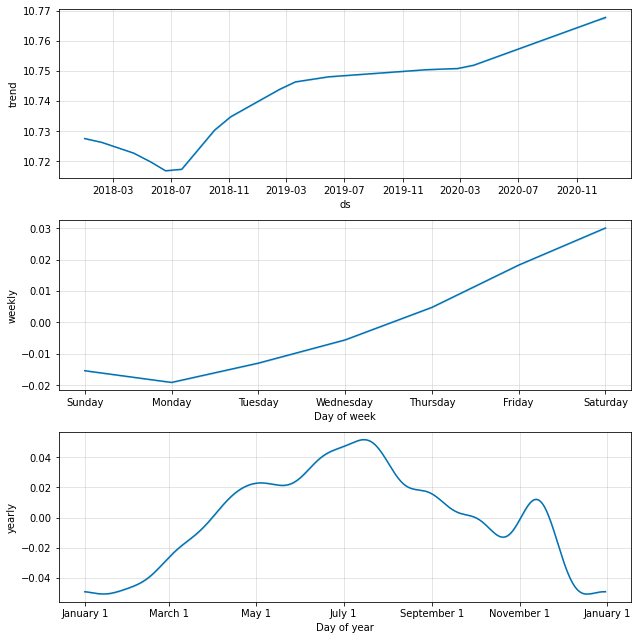

In [ ]:
# plotando os componentes
m.plot_components(forecast).savefig('st_components.png')

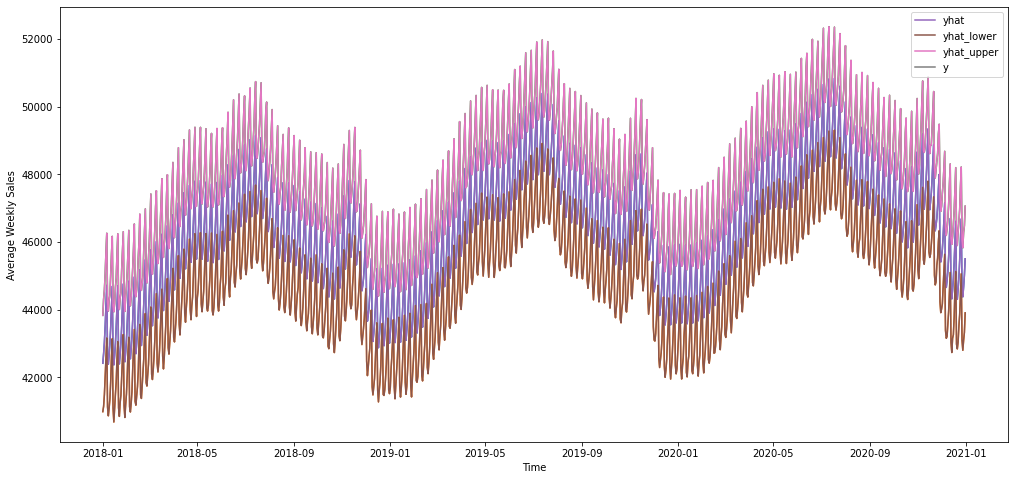

In [ ]:
# checando os resultados
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])

plt.xlabel('Time')
plt.ylabel('Average Weekly Sales')
ax.plot(cmp_df['yhat'], label='yhat')
ax.plot(cmp_df['yhat_lower'], label='yhat_lower')
ax.plot(cmp_df['yhat_upper'], label='yhat_upper')
ax.plot(cmp_df['y'], label='y')
ax.legend()
plt.show()

In [ ]:
cmp_df.head()

yhat    yhat_lower    yhat_upper   y
ds                                                               
2018-01-01 00:00:00  42416.610002  40987.727624  43831.738993 NaN
2018-01-02 00:00:00  42698.457485  41142.597291  44308.538488 NaN
2018-01-03 00:00:00  43036.690306  41488.914608  44588.734817 NaN
2018-01-04 00:00:00  43515.058665  41994.493937  45066.870980 NaN
2018-01-05 00:00:00  44155.518954  42567.833406  45719.036761 NaN

In [ ]:
# reutilizando a função
def make_comparison_dataframe(historical, forecast):
  return forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(historical.set_index('ds'))
cmp_df = make_comparison_dataframe(df_log, forecast)

# calculando MAPE e MAE
def calculate_forecast_errors(df_ts, prediction_size):

  df = df_ts.copy()
  df['e'] = df['y'] - df['yhat']
  df['p'] = 100 * df['e'] / df['y']
  predicted_part = df[-prediction_size:]

  error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

  return{'MAPE': error_mean('p'), 'MAE': error_mean('e')}

# imprimindo o MAPE e MAE
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
  print(err_name, err_value)

MAPE 0.20188586841484438
MAE 0.021608799725004544


## Conclusões - Séria Estacionária

Agora sim, temos um resultado bastante convincente!

Com erro muito baixo, temos resultados muito bons para apresentar! Só temos um detalhe pra consertar.

Ao fazer a transformação para a série não estacionária nós colocamos os dados em uma outra escala, e precisamos trazê-los para valores condizentes com o data set original.

Como nós fizemos uma transformação com log, vamos trazer de volta com uma transformação de exponencial.

In [ ]:
# criando um dataset completo
df_final = forecast[['ds', 'yhat']]
df_final.head()

ds       yhat
0 2018-01-01  10.659254
1 2018-01-02  10.665302
2 2018-01-03  10.672574
3 2018-01-04  10.682794
4 2018-01-05  10.696104

In [ ]:
# visualizando as previsões dentro de um dataframe
df_final['AmountSpentLog'] = df_log['y']
df_final.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ds       yhat  AmountSpentLog
0 2018-01-01  10.659254       10.678952
1 2018-01-02  10.665302       10.673156
2 2018-01-03  10.672574       10.675862
3 2018-01-04  10.682794       10.650555
4 2018-01-05  10.696104       10.645449

Agora vamos criar um dataset que contenha:

* Data (`ds`)
* Previsão do Prophet (`yhat`)
* Valor Gasto Real (`AmountSpent`)
* Valor Gasto Previsto na escala correta (`AmountSpentPred`)

In [ ]:
# colocando os valores na escala original
df_final['AmountSpent'] = np.exp(df_final['AmountSpentLog'].values)
df_final['AmountSpentPred'] = np.exp(df_final['yhat'].values)
df_final.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


ds       yhat  AmountSpentLog  AmountSpent  AmountSpentPred
0 2018-01-01  10.659254       10.678952      43432.0     42584.857172
1 2018-01-02  10.665302       10.673156      43181.0     42843.185578
2 2018-01-03  10.672574       10.675862      43298.0     43155.888128
3 2018-01-04  10.682794       10.650555      42216.0     43599.210045
4 2018-01-05  10.696104       10.645449      42001.0     44183.393595
5 2018-01-06  10.707738       10.663522      42767.0     44700.416922
6 2018-01-07  10.662038       10.682400      43582.0     42703.566160
7 2018-01-08  10.658111       10.673179      43182.0     42536.194385
8 2018-01-09  10.664078       10.684646      43680.0     42790.764917
9 2018-01-10  10.671313       10.684783      43686.0     43101.510807

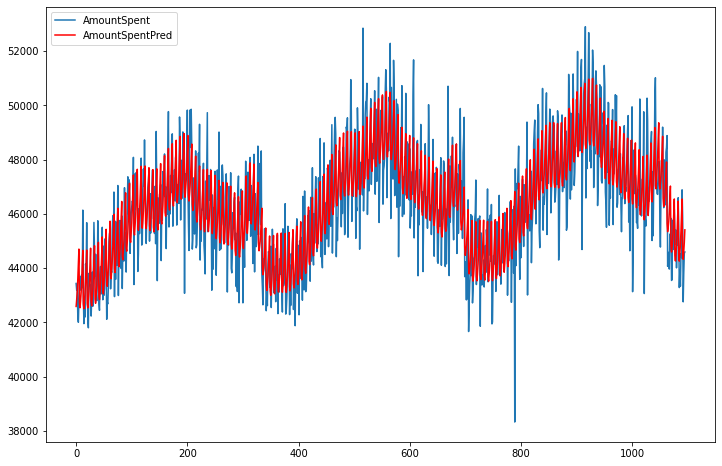

In [ ]:
# plotando previsões vs realidade
fig, ax = plt.subplots(figsize=(12,8))
df_final['AmountSpent'].plot(ax=ax, legend=('Amount Spent'))
df_final['AmountSpentPred'].plot(ax=ax, color='r', legend={'Predicted'})
plt.savefig('st_yhat.png')
plt.show()


Aqui podemos ver que o nosso modelo está mais próximo dos limites superiores que dos inferiores, mas em geral, em um ponto médio.

Para visualizar previsões mais otimistas, poderíamos considerar o `yhat_upper`, e para previsões mais pessimistas, o `yhat_lower`.